In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt     # 필요한 library 선언 !!

class Sin():   # sin 함수 기반 회귀모델 정의하는 클래스
    def __init__(self, epochs):
        self.epochs = epochs    # 학습 몇 번 돌릴지 정해주는 값 저장

        # 우리가 학습할 식은 y = a * sin(w * x) + b 이런 형태라는 뜻!
        # 그래서 a, w, b라는 숫자를 학습할 수 있도록 파라미터로 만들어줌
        self.a = torch.nn.Parameter(torch.ones(1, requires_grad= True))
        self.w = torch.nn.Parameter(torch.ones(1, requires_grad= True))
        self.b = torch.nn.Parameter(torch.ones(1, requires_grad= True))

    def fit(self, X, y):    # 모델 학습시키는 함수 정의
        # optimizer로 Adam 사용할것이고 a, w, b를 학습할 수 있게 등록
        optimizer = torch.optim.Adam((self.a, self.w, self.b), lr = 1e-3)
        # 손실 함수로 MSE 사용 선언(예측값과 정답의 차이를 제곱하여 평균낸 값)
        criterion = torch.nn.MSELoss()

         # epochs만큼 학습 돌리기
        for i in range(self.epochs):
             # loss값 계싼
            loss = criterion(self.a*torch.sin(self.w*X)+self.b, y)
            # 그래디언트 초기화 -> 역전파 -> 파라미터 업데이트 반복
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        return self
    
    def predict(self, X):   # 예측값 계산 함수 정의
        # 학습한 파라미터로 예측값 계산
        pred = self.a * torch.sin(self.w * X)+ self.b
        # tensor를 numpy로 바꿔서 그래프 그리기 편하게 변환
        return pred.detach().numpy()
            

In [3]:
class Sigmoid():
    def __init__(self, epochs):
        self.epochs = epochs    # 학습 반복 횟수 저장
        # y = k * sigmoid(t * x) + a 형태의 식에서 학습할 파라미터 초기화
        self.k = torch.nn.Parameter(torch.randn(1, requires_grad = True))
        self.t = torch.nn.Parameter(torch.randn(1, requires_grad = True))
        self.a = torch.nn.Parameter(torch.randn(1, requires_grad = True))
    
    def fit(self, X, y):    # 학습 함수 정의
        def sigmoid(x):
            return 1 / (1+torch.exp(-x))
        # Adam optimizer 설정
        optimizer = torch.optim.Adam((self.k, self.t, self.a), lr = 1e-3)
        # Adam optimizer 설정
        criterion = torch.nn.MSELoss()

        for i in range(self.epochs):    
            # loss = torch.mean((y - (self.k*sigmoid(self.t*X)+self.a))**2) #이것도 가능하다..!  
            # 이렇게도 가능!  
            # pred = self.k * sigmoid(self.t * X) + self.a
            # loss = criterion(pred, y)        
            loss = criterion(self.k*sigmoid(self.t*X) + self.a, y)  # 손실값 계산

             # 학습 단계
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        return self

    def predict(self, X):
        def sigmoid(x):
            return 1 / (1+torch.exp(-x))
        pred = self.k*sigmoid(self.t*X) + self.a
         # 예측값 계산 후 numpy로 변환
        return pred.detach().numpy()

In [4]:
class Regression_comparer:  # 모델 비교 Class
    def __init__(self, models):
        self.models = models
        # 나중에 결과들을 저장해두려고 딕셔너리 하나 준비
        self.results = {}

    def r2(self, y, y_pred):  # R2(결정계수) 계산 함수
        ssr = torch.sum((y - y_pred) ** 2) # SSR = 차이 제곱합
        sst = torch.sum((y - torch.mean(y)) ** 2) # SST = 총 제곱합
        return 1 - ssr / sst    # r2 = 1 - SSR / SST

    def mae(self, y, y_pred): # MAE (Mean Absolute Error) 계산 함수
        return torch.mean(torch.abs(y - y_pred))  # 예측값과 실제값 차이 절댓값의 평균

    def rmse(self, y, y_pred): # RMSE (Root Mean Squared Error) 계산 함수
         # 예측값이랑 실제값 차이 제곱 -> 평균 -> 루트
        return torch.sqrt(torch.mean((y - y_pred) ** 2))

    def compare(self, X, y): # 모델들의 성능을 비교할 함수

        for name, model in self.models.items():
            model.fit(X, y) #모델 학습
            # 예측값 구하기
            y_pred = model.predict(X)

             # 각 성능지표 계산해서 출력!
            print(f"""model : {name}
    'R2': {self.r2(y, y_pred):.4f},
    'MAE': {self.mae(y, y_pred):.4f},
    'RMSE': {self.rmse(y, y_pred):.4f}
            """)
            print("-" * 20)

model : Sigmoid
    'R2': -1.1410,
    'MAE': 21.7821,
    'RMSE': 29.7117
            
--------------------
model : Sin
    'R2': -1.0647,
    'MAE': 21.1348,
    'RMSE': 29.1771
            
--------------------


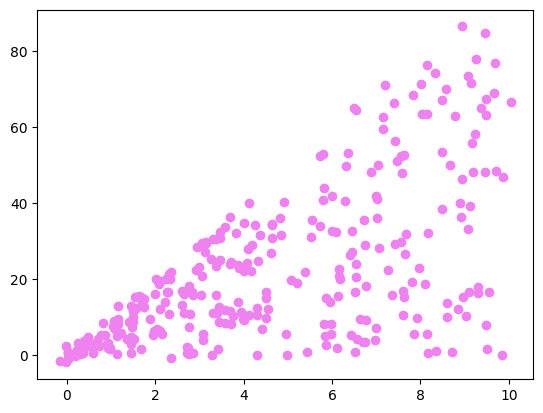

In [5]:
# Sigmoid 모델 객체 생성 (epochs=50으로 설정)
a = Sigmoid(50)
# Sin도 동일
b = Sin(50)
# 나중에 비교할 때 쓰기 위해 딕셔너리로 저장
first = {'Sigmoid' : a,
         'Sin' : b}

#학습용 데이터 추가(+ 노이즈)
x_train = torch.rand(300)*1e1 + torch.randn(300)*1e-1
y_train = torch.rand(300)*(x_train)*1e1 + torch.randn(300)*1e0  

# 데이터 산점도 찍기
plt.scatter(x_train, y_train, color ='violet')
# 모델 비교 머신
compare_machine = Regression_comparer(first)
# 각 모델로 학습 -> 예측 -> 성능 지표(R2, MAE, RMSE) 출력
compare_machine.compare(x_train, y_train)


In [6]:
# ------ 실제 데이터 -------

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# 엑셀 파일 읽기 (파일명 바꿔줘!)
df = pd.read_excel("data.xlsx")

# GDP, 자살률 데이터의 열 가져오기
X_raw = df["GDP"].values
y_raw = df["자살률"].values

# numpy -> torch Tensor로 변환
X = torch.tensor(X_raw, dtype=torch.float32).reshape(-1, 1)
y = torch.tensor(y_raw, dtype=torch.float32).reshape(-1, 1)

# 모델 딕셔너리 준비
models = {
    "Sin": Sin(epochs=3000),    #위에서 선언한 모델
    "Sigmoid": Sigmoid(epochs=3000)
}

# 비교 클래스 생성
comparer = Regression_comparer(models)

# 학습 및 성능 비교
comparer.compare(X, y)


model : Sin
    'R2': -1.1991,
    'MAE': 7.1999,
    'RMSE': 9.1305
            
--------------------
model : Sigmoid
    'R2': -0.9371,
    'MAE': 6.6216,
    'RMSE': 8.5693
            
--------------------
